In [1]:
# !pip3 install -q -r requirements.txt
# !pipreqsnb --force

## [Proceed to results](#results)

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import tqdm.notebook as tqdm

import gymnasium as gym
import numpy as np
import random
import time

import torch
import torch.nn as nn
import torchsummary as summary
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

from IPython import display
import imageio
import os
FP = './animations'

In [2]:
ENV = gym.make("MountainCarContinuous-v0", render_mode='rgb_array')
SS = ENV.observation_space # continuous 
DIM_S = SS.shape[0] # 2-dimensional (position, velocity) continuous, [-inf, +inf] for both
AS = ENV.action_space # finite action space, 4 actions
DIM_A = AS.shape[0] # 1-dimensional continuous force within [-1, +1] range

In [4]:
# stochastic init state
ENV.reset()

(array([-0.40914744,  0.        ], dtype=float32), {})

In [3]:
def rr(env=ENV, capture=False):
    """quick render fix assuming env's render_mode='rgb_array' """
    # plt.figure(figsize=(5,10))
    arr = env.render()
    if capture:
        return arr
    else:
        plt.axis('off')
        plt.imshow(arr)
               
def act(action, env=ENV):
    """filters unnecessary output"""
    return env.step(action)[:3]

In [6]:
new_state = act(np.array([0.3])) # [state, reward, done, info, ...]
new_state

(array([-4.0953904e-01, -3.9161803e-04], dtype=float32), -0.009, False)

In [4]:
class CRandAgent():
    """baseline agent that performs random actions=np.arrays with shape (1,) and values within [-1, 1]"""
    def __init__(self, d_actions=DIM_A):
        self.d_actions = d_actions
        self.rendered_frames = []
        
    def act(self, state):
        action = np.random.uniform(low=-1, high=1, size=self.d_actions)
        # print('RANDOM!!')
        return action

    def capture(self, max_length, fpath=FP):
        """captures render output and creates gif animation from frames"""
        self.rendered_frames = []
        self.walk(max_length, render=2)
        name = ENV.unwrapped.spec.id + '.gif'
        path = os.path.join(fpath, name)
        imageio.mimsave(path, ims=self.rendered_frames, fps=30)
        print(f'Capture result has been saved to {path}')

    def walk(self, max_length, render=False, injected=10, **actkwargs):
        """take max_length actions by agent N"""
        states, actions, rewards = [], [], []

        # initialization state
        state = ENV.reset()[0]
        # inject = np.array(np.random.choice([-1., 1.], size=self.d_actions))
        # for _ in range(injected):
        #     act(inject)
        for i in range(max_length):
            # perform an action
            action = self.act(state, **actkwargs)
            new_state, reward, done = act(action)
            # log 
            actions.append(action)
            states.append(state) # append OLD state, everything breaks if you start from new
            rewards.append(reward)
            state = new_state
            # continuous visualization w/ proper interrupt
            if render:
                try:
                    if render == 2:
                        arr = rr(capture=True)
                        self.rendered_frames.append(arr)
                    else:
                        rr()
                        display.display(plt.gcf())
                        time.sleep(1e-4)
                        display.clear_output(wait=True)
                except KeyboardInterrupt:
                    break
            if done:
                break
        trajectory = {'s': states,
                        'a': actions,
                            'r': rewards,}
        return trajectory

-0.42657558766182824

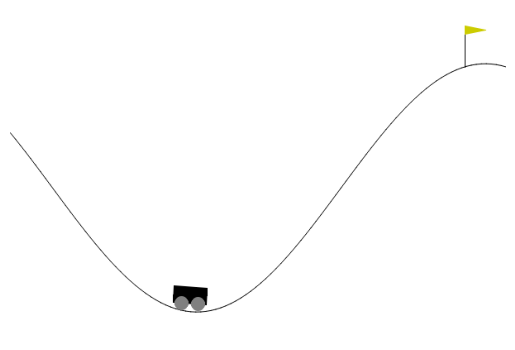

In [430]:
agent = CRandAgent()
results = agent.walk(max_length=20, render=True)
sum(results['r'])

In [5]:
# auxillary functions
def lin_ann_rate(i, n_total):
    return 1 - i / n_total

def exp_ann_rate(i, thr=0.0001, la=2/300, drop=0.001):
    """exponential decay with i --> +inf, provides descending values within range [1, thr],
        la=0.01 means ~36% left after 100 iterations, results < drop value are zeroed"""
    exp = np.exp if isinstance(i, np.ndarray) else torch.exp
    result = thr + (1 - thr) * exp(- la * i)
    if drop:
        result[result <= drop] = 0
    return result

def sgm_ann_rate(i, mid, alpha=1e-2, drop=0):
    """symmetic sigmoidal decay within [0, 2*mid-1] provides descending values within range [1-alpha, alpha], results < drop value are zeroed,
        alpha controls the gap between function value and its asymptotes (i=1/i=0)"""
    # establish max possible smoothness given alpha and symmetrize wrt mid value (this form has been pre-simplified and doesn't depend on exp or log realisation)
    result = (1 + (1/alpha - 1) ** ((i - mid)/mid) )**(-1)
    if drop:
        result[result <= drop] = 0
    return result

def anneal_comparison(n=500):
    i = np.arange(n)
    ax = sns.lineplot(lin_ann_rate(i, n), linewidth=1.2, label=f"base")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f"Annealing rates comparison", fontsize=15)
    ax.set_xlabel('iterations - 1')
    for j in np.arange(1e-5, 1e-1, 1e-2):
        result = sgm_ann_rate(i, mid=n/2 - 1, alpha=j, drop=0)
        ax = sns.lineplot(result, linewidth=1, ax=ax, label=f"a={j:.1e}")

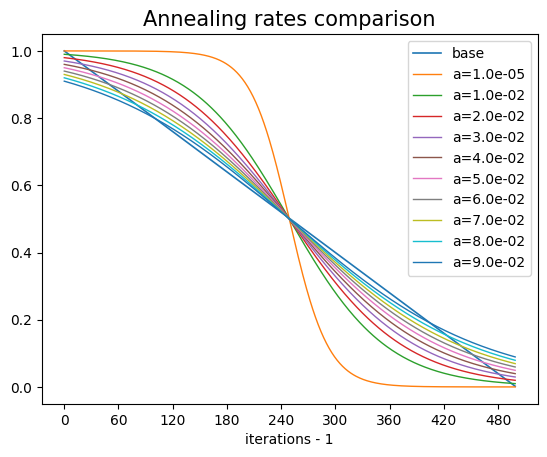

In [6]:
anneal_comparison()

In [431]:
def U_noise(dim, pr3v=None):
    """multi-dimensional Uniform noise within interval -1, +1"""
    return torch.Tensor((dim,)).uniform_(-1, 1)
    
def G_noise(dim, pr3v=None):
    """multi-dimensional Gauss noise with mean=0 and std=1"""
    return torch.randn(dim)
    
def OU_noise(dim, pr3v):
    """multi-dimensional random noise generated by Ornstein–Uhlenbeck process"""
    dp = {'theta': 0.15, 'delta': 0.01, 'mu': torch.zeros(dim), 'sigma': 0.1 * torch.ones(dim), 'eps': G_noise(dim)} # default params for RL application
    n3xt = pr3v + (dp['mu'] - pr3v) * dp['theta'] * dp['delta'] + dp['sigma'] * torch.sqrt(torch.tensor(dp['delta'])) * dp['eps']
    return n3xt

def sample_noise(dim=1, n_iterations=100, scale=(1, 20), show_limits=True, anneal=True):
    """plots consequent noise sample of size 100"""
    pr3v = torch.zeros(dim, )
    g, ou = [], []
    for i in range(n_iterations):
        if anneal:
            rate = sgm_ann_rate(i, mid=n_iterations/2 - 1, alpha=1e-01)
        g.append(scale[0] * rate * G_noise(dim, pr3v))
        pr3v = OU_noise(dim, pr3v)
        ou.append(scale[1] * rate * pr3v)
    g, ou = np.array(g), np.array(ou)
    plt.plot(g, linewidth=1.0, label=f"Gauss noise, s={scale[0]}")
    plt.plot(ou, linewidth=1.2, label=f"OU noise, s={scale[1]}")
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f"", fontsize = 10)
    ax.set_xlabel('iterations - 1')
    # ax.set_yscale('symlog')
    plt.legend()
    if show_limits:
        ax.axhline(y=max(g), color='r', linestyle='-', linewidth=0.5)
        ax.axhline(y=max(ou), color='g', linestyle='-', linewidth=0.5)
        ax.axhline(y=min(g), color='r', linestyle='-', linewidth=0.5)
        ax.axhline(y=min(ou), color='g', linestyle='-', linewidth=0.5)

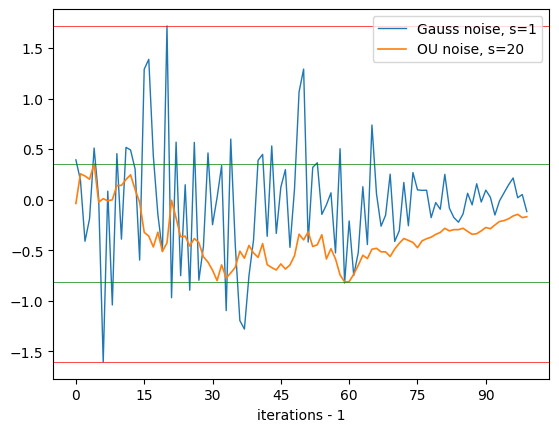

In [391]:
sample_noise()

In [432]:
class CrossEntropyNNCAgent(CRandAgent):
    def __init__(self, noise_fn=G_noise, d_states=DIM_S, d_actions=DIM_A, hidden_d=(120, None), device=DEVICE):
        """CrossEntropy algorithm actor, optimizes expected reward by policy, given by neural network"""
        super().__init__(d_actions)
        self.d_states = d_states
        
        self.scale = 0
        self.noise_fn = noise_fn
        self.noise = torch.zeros(self.d_actions)
        
        self.loss = nn.MSELoss()
        self.device = device
        self.model = nn.Sequential(
            nn.Linear(in_features=self.d_states, out_features=hidden_d[0]),
            nn.ReLU(),
            # nn.Linear(hidden_d[0], hidden_d[1]),
            # nn.ReLU(),
            nn.Linear(hidden_d[0], d_actions),
        )
        
        self.log = []
        self.hp = {}

    def act(self, state):
        """policy = action given by tanh(network output) + random noise within [0..1] 
            otherwise this policy would be almost completely deterministic (as NN is except its initialization)
            clipper is used instead of tanh due to just to fit result into action space min max limits"""
        with torch.inference_mode(): 
            self.noise = self.noise_fn(dim=self.d_actions, pr3v=self.noise)
            # action = nn.functional.tanh(self.model(torch.Tensor(state)).detach() + self.scale * self.noise) 
            action = self.model(torch.Tensor(state)).detach() + self.scale * self.noise
            action_c = torch.clip(action, min=-1, max=1)
        return action_c.numpy()

    def learning_curve(self, show_max=True, ax=None):
        """plots rewards vs iterations of algorithm"""
        ax = sns.lineplot(self.log, linewidth=1.0, ax=ax, label=f"lr={self.hp['lr']}")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(f"Mean reward over {self.hp['n_trajectories']} trajectories of length < {self.hp['max_length']}", fontsize = 10)
        ax.set_xlabel('iterations - 1')
        # ax.set_yscale('symlog')
        ax.legend()
        if show_max:
            ax.axhline(y=max(self.log), color='r', linestyle='-', linewidth=0.5)
        return ax
        
        
    def fit(self, n_iterations, max_n_epochs, noise_scale, lr=0.01, n_trajectories=100, max_length=50, q=0.8, verbose=None):
        """
        CE Algorithm has 2 steps per iteration: evaluate policy, improve policy
        Our goal is to maximize expected reward ER which is unreachable => approximated
        
        n_trajectories (w/ length <= max_length) defines quality of ER approximation
        0<q<1 controls rejected quantile of trajectories

        max_n_epochs controls max possible NN training epochs per each iteration

        lr defines learning rate of built-in Adam optimizer
        
        verbose>0 sets up a period of learning process rendering

        NB: .fit internally uses .act method of child class(this), doesn't inherit parental
        """
        # save fitting hyperparameters for comparison
        ap = locals()
        self.hp = {k: ap[k] for k in ap.keys() - ['self', 'verbose', 'n_iterations', 'n_epochs']}
        self.model.to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        iterations_pbar = tqdm.trange(n_iterations, position=0, leave=True, colour="#a2d2ff")
        dh = display.display(display_id=True)
        scale_0 = self.scale = noise_scale
        scales = []
        for i in iterations_pbar:
            self.model.eval()
            # policy evaluation (act with current policy or sample n_det deterministic from that one)
            trajectories = [self.walk(max_length=max_length) for t in range(n_trajectories)]
            rewards = np.stack([np.sum(t['r']) for t in trajectories])
            avg_reward = np.mean(rewards)
            self.log.append(avg_reward)
            # policy improvement
            # get q-quantile of current reward distribution and filter out better trajectories
            gamma = np.quantile(rewards, q)
            elite_ids = (rewards > gamma).nonzero()[0]
            if elite_ids.any():
                # extract (lists of) state and (corresponding) action tensors from elite trajectories
                states_l, actions_l = zip(*((np.stack(trajectories[ei]['s']), np.stack(trajectories[ei]['a'])) for ei in elite_ids))
                states, actions = torch.Tensor(np.concatenate(states_l)).to(self.device), torch.Tensor(np.concatenate(actions_l)).to(self.device)
                epochs_pbar = [0] if (max_n_epochs == 1 or i==0) else tqdm.trange(n_epochs, position=1, leave=False, colour="#ffc8dd") # order matters
                self.model.train()
                for e in epochs_pbar:
                    # forward pass
                    pred_actions = self.model(states)
                    loss = self.loss(pred_actions, actions)
                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                # noise scale (descends from scale_0 to 0)
                self.scale = scale_0 * sgm_ann_rate(i, mid=n_iterations/2 - 1, alpha=1e-01)
                scales.append(self.scale)
                # less stochastic gradients (ascending from 1 to max_n_epochs)
                n_epochs = 1 + round((1 - exp_ann_rate(torch.Tensor([i]), thr=0, la=2/n_iterations, drop=None).item()) * (max_n_epochs - 1))
                iterations_pbar.set_postfix_str(f'avg reward: {avg_reward.item():.2f}, loss: {loss.detach().item():.2e}, scaled_noise: {self.scale*self.noise.item():.2f}, n_epochs: {n_epochs}', refresh=True)
            
            # visualization (plotting starts after at least 1 iteration)
            if verbose and i > 0 and (i + 1) % verbose == 0:
                # print(f"iteration {i + 1}, mean total reward: {avg_reward}")
                figure, axes = plt.subplots(1, 2, figsize=(12,5))
                ax = self.learning_curve(ax=axes[0])
                
                ax2 = ax.twinx()
                # ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
                ax2.tick_params(axis='y', labelcolor='slateblue')
                sns.lineplot(scales, linewidth=0.5, ax=ax2, label="noise scale", color='slateblue')
                
                ax = sns.histplot(rewards, kde=False, bins=20, ax=axes[1])
                ax.axvline(gamma, 0, 20, color='r')
                ax.set_xlabel('Rewards')
                ax.set_title(f'Current distribution of rewards and its {q:.2f}-quantile ', fontsize = 10)
                
                dh.update(plt.gcf())
                plt.close() # because plt.clf() is spurious
        return avg_reward

  0%|          | 0/100 [00:00<?, ?it/s]

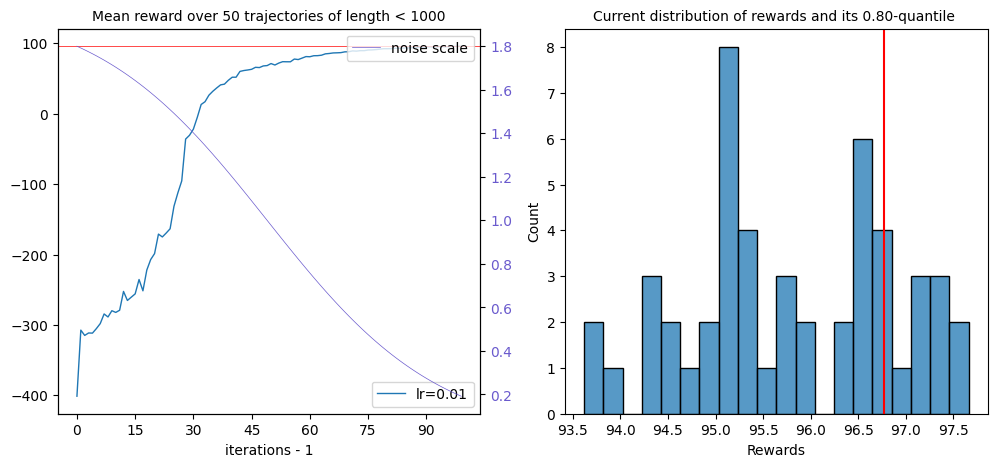

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

95.79276112842543

In [433]:
agent_nnc = CrossEntropyNNCAgent(noise_fn=G_noise)
agent_nnc.fit(n_iterations=100, max_n_epochs=10, noise_scale=2, lr=0.01, n_trajectories=50, max_length=1000, q=0.8, verbose=1)

  0%|          | 0/100 [00:00<?, ?it/s]

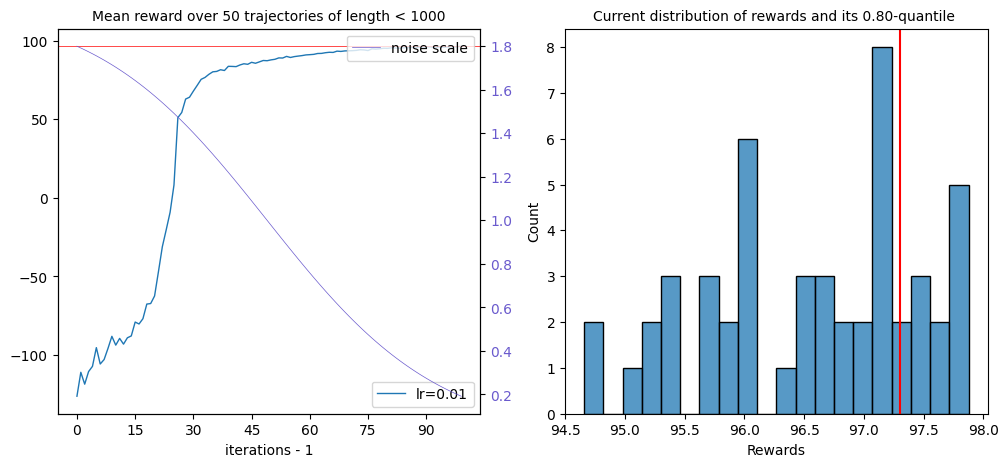

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

96.56307221969861

In [119]:
agent_nnc4u = CrossEntropyNNCAgent(noise_fn=U_noise)
agent_nnc4u.fit(n_iterations=100, max_n_epochs=10, noise_scale=2, lr=0.01, n_trajectories=50, max_length=1000, q=0.8, verbose=1)

In [323]:
results = agent_nnc.walk(max_length=1000, render=2)
sum(results['r'])

89.70873963206421

<a id="results"></a>

# Main problem
Mountain-car is an example of underactuated task: we have to (repeatedly) swing back and forth (costly) to reach top of the hill. Put it another way, we must perform a lot of suboptimal (as the magnitude is penalised ~ $force^2$) actions before any reward comes. Due to [this reward scheme](https://www.gymlibrary.dev/environments/classic_control/mountain_car/), successful event happens so rare that doing nothing is considered the only option, i.e. we are stuck in a local maxima(

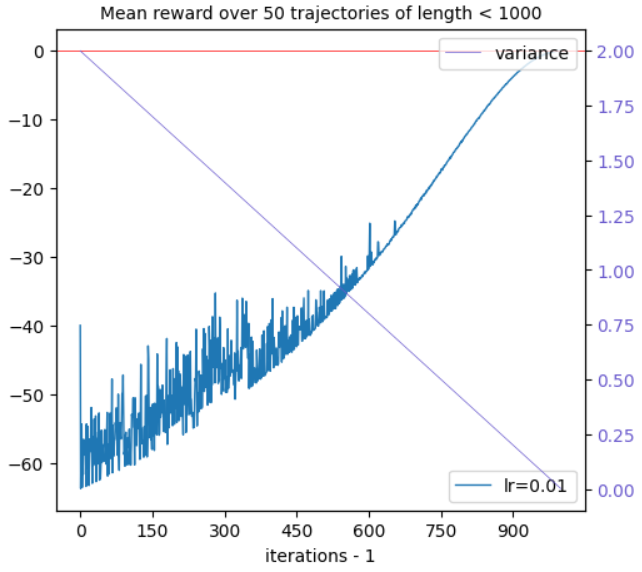

We should somehow force our model to perform non-local exploration ~ inject some energy into the system
## Random noise as a key to solution
Additional action noise (its scale **noise_scale**, type and so on) is extremely important here; particularly this task benefits from large noise scales. 
Constant noise impacts learning efficiency, that is why i am going to use some schedule to decrease throughout learning process (number of iterations). 
Since we need more noise at the very beginning I've decided to use sigmoidal one instead of exponential/linear decay rules
## Forced initialization
I tried to start with a pulse, i.e. sequetial actions w largest velocity in one but random direction (ENV.reset() sets zero velocity by default)...no effect (or I weren't patient enough)
## Different loss
I could have used L1 Loss instead of L2 but the problem isn't just that, so I stick to L2
# Results
I train internal NN for 1..**max_n_epochs** at each iteration as before (jic) and it seems that NN architecture and **lr** don't have much influence on convergence unlike the type of chosen noise and its scale
## Architecture search
Most of compared architectures solve this task (sooner or later) becoming almost indistinguishable after 70 iterations and even 5-neuron network still fits for the task.
So, this choice doesn't really matter unless it's intentionally bad: smaller than 30 neurons or larger than 250. Deeper NN architectures tend to require more neurons to solve (at least with gaussian noise) but still perform generally worse so shouldn't be used

One useful thing here is tanh evasion to maximize gain at the ends of interval, instead I use simple clipping (this environment has built-in clipper but i want to make it explicit)

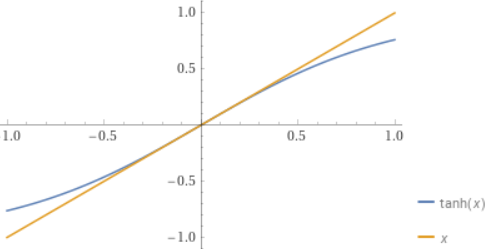

An architecture containing just a single (hidden) layer of 120 neurons outperforms (faster finds path to solution) everything else here:

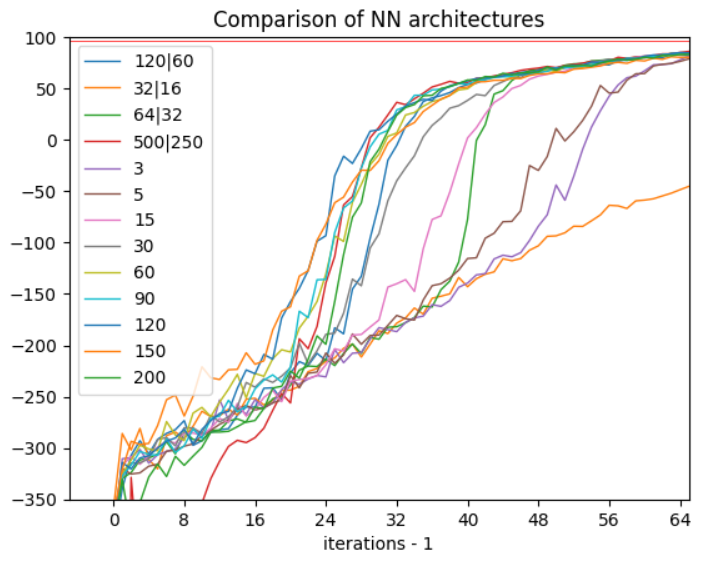
## Noise comparison
I want to try other than most common options for noise distribution, for example:

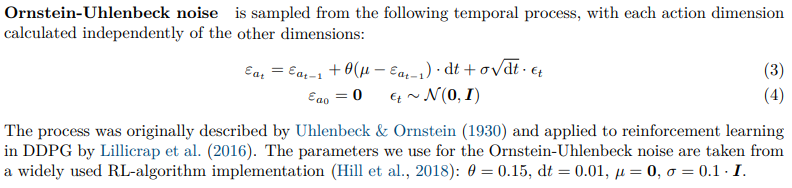

Let's plot 100 consequent samples and modulate by sigmoidal decay (the one I use during training)

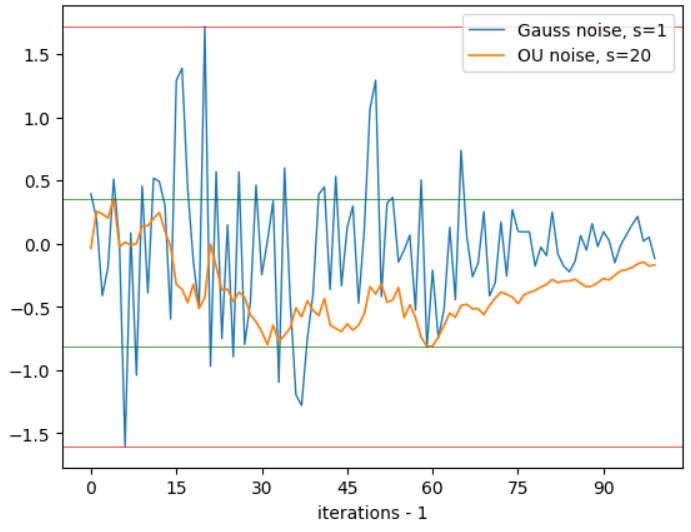

It seems strange that Ornstein-Uhlenbeck process noise may outperform Gaussian/Uniform noise at the beginning (despite its lower magnitude, $20OU \sim 1G$) but always yields lower & unstable results at the end. This might be an issue: the process itself is stationary, but provides small pulses in the same direction long enough (i.e. magnitude of each spike doesn't matter that much in comparison with their duration)

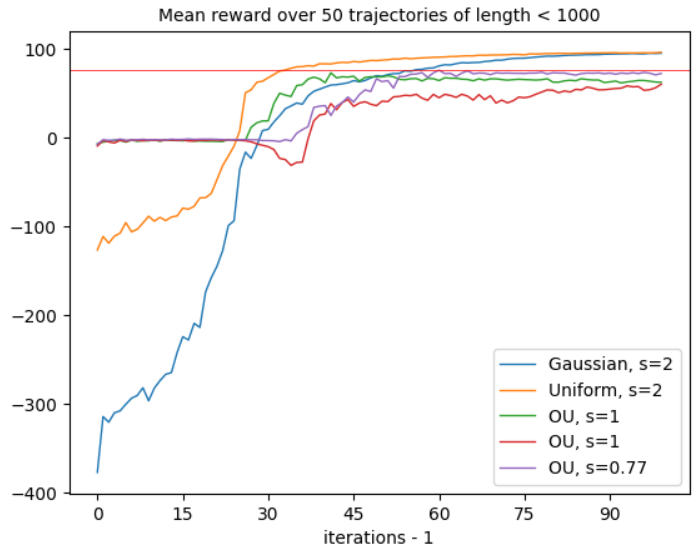

For some reason this type of noise (w/ appropriate scale) allows to reach ok results even with a bad NN architecture

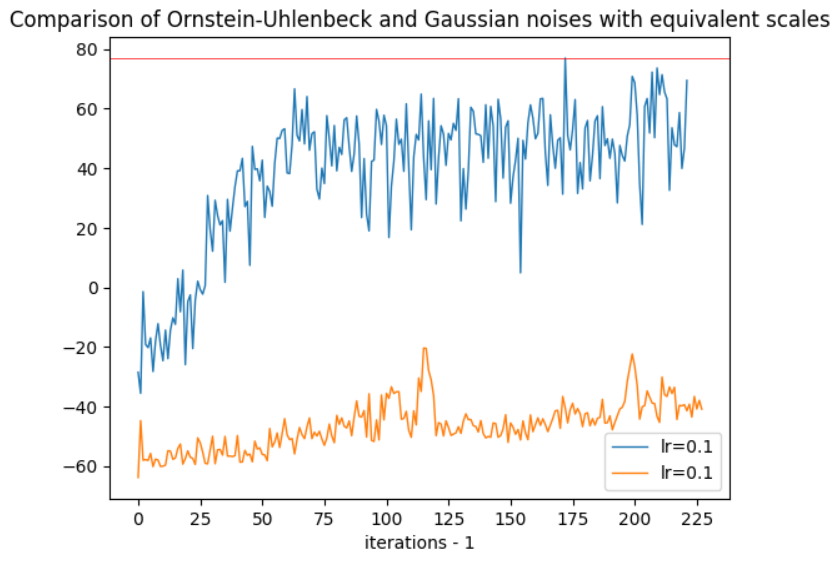